In [1]:
library(xts)
library(dplyr)
library(gdata)
library(deseasonalize)
library(WiSEBoot)
library(ggplot2)
library(scales)

Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Attaching package: ‘dplyr’

The following objects are masked from ‘package:xts’:

    first, last

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

gdata: read.xls support for 'XLS' (Excel 97-2004) files ENABLED.

gdata: read.xls support for 'XLSX' (Excel 2007+) files ENABLED.

Attaching package: ‘gdata’

The following objects are masked from ‘package:dplyr’:

    combine, first, last

The following objects are masked from ‘package:xts’:

    first, last

The following object is masked from ‘package:stats’:

    nobs

The following object is masked from ‘package:utils’:

    object.size

The following object is masked from ‘package:base’:

    startsWith

Loading required package: lattice
Loading required package: FitAR
Loading

In [2]:
p_deseasonalize <- function(series, p){

    even <- FALSE
    
    if (p %% 2 == 0){
        even <- TRUE
    }
    
    if (even){
        
        # even formula
        series_lead <- lead(series, p/2)
        series_lag <- lag(series, p/2)

        series_t <- cbind(series_lead, series_lag)

        for(i in seq(from = -p/2 + 1, to = p/2 - 1, by = 1)){

            # is i -ve
            if (i < 0){
                series_temp <- lag(2 * series, -i)
            } else {
                series_temp <- lead(2 * series, i)
            }
            series_t <- cbind(series_t, series_temp)
        }

        value <- rowSums(series_t[,])/(2*p)

        return (value)
        
    } else {
        
        # odd formula
        series_t <- numeric(length(series))

        for(i in seq(from = -(p-1)/2, to = (p-1)/2, by = 1)){

            # is i -ve
            if (i < 0){
                series_temp <- lag(series, -i)
            } else {
                series_temp <- lead(series, i)
            }
            series_t <- cbind(series_t, series_temp)
        }

        value <- rowSums(series_t[,])/p
        
        return (value)
    }
    
}

In [3]:
periodic_add <- function(s, p, r){
    
    # s -> series
    # p -> period: 4
    # r -> number of seasonal cycles: 3
    # rs -> series to be returned
    
    rs <- s[1:p]
    
    for (i in seq(1, r-1, by = 1)){
        start <- p*i+1
        end <- p*i+p
        rs <- rs + s[start:end]
    }
    
    return (rs)
    
}

In [20]:
forecast_timeseries <- function(ser, date, p, r, start_pred_date, month_start = 0, m_gap = "1 month"){
    
    # parameters
#     ser -> original time series
#     date -> original time series date/time index
#     month_start -> 0 or 1. 0 if date starts from 1st day of the month and 1 if date starts from the end i.e. 30
#     p -> cycle length
#     r -> number of cycles
#     start_pred_date -> prediction date starting
#     m_gap -> gap between the months in Date, like 3 month for quarter time series
    
    # Index
    ind <- seq(0, length(ser)-1)

    # Time Series + Index dataframe
    df <- data.frame(ind, ser)

    # Time Series xts object
    data <- xts(df, order.by = date)
    
    # Preparing prediction parameters
    pred_l <- p * 1

    predicted_date <- seq(start_pred_date, length = pred_l, by = m_gap) - month_start
    
#     print (predicted_date)

    predicted_t <- seq(nrow(data), nrow(data) + pred_l - 1)
    
    colnames(data) <- c("t", "original")

    # Adding deseasoned data along with t
    data <- merge(data, p_deseasonalize(coredata(data$original), p))

    colnames(data)[3] <- c("deseasonalized")

    fit <- lm(deseasonalized ~ t, data)

    dt_bar <- predict(fit, data.frame(t = ind))

    dt_bar <- xts(dt_bar, order.by = date)

    st_bar <- xts(data$original/dt_bar, order.by = date, name = "st_bar")

    colnames(st_bar) <- c("st_bar")

    data <- merge(data, dt_bar, st_bar)

    # Prediction
    predicted_st <- periodic_add(coredata(data$st_bar), p, r)/r

    predicted_dt_bar <- predict(fit, data.frame(t = predicted_t))

    predicted_st_bar <- numeric(length(predicted_t))

    predicted_ft <- predicted_dt_bar * predicted_st

    predicted_deseasonalized = numeric(length(predicted_t))

    predicted = data.frame(t = predicted_t, original = as.integer(predicted_ft), deseasonalized = predicted_deseasonalized,
                           dt_bar = as.integer(predicted_dt_bar), st_bar = predicted_st_bar)

    predicted <- xts(predicted, order.by = predicted_date)

    g1 <- ggplot(data, aes(x = Index, y = original)) + 
      geom_point(aes(x = Index, y = original, colour = "original")) +
      geom_line(aes(x = Index, y = original, colour = "original")) +
      geom_point(aes(x = Index, y = deseasonalized, color = "deseasonalized")) +
      geom_line(aes(x = Index, y = deseasonalized, color = "deseasonalized")) +
      geom_point(aes(x = Index, y = dt_bar, color = "dt_bar")) +
      geom_line(aes(x = Index, y = dt_bar, color = "dt_bar")) +
      scale_colour_manual("Legend", values = c("original" = "blue", "deseasonalized" = "red", "dt_bar" = "green")) +
      labs(x = "Time", y = "Value")

    total <- rbind(data, predicted)
    
    indices <- c(date, predicted_date)

    total_df <- data.frame(Index = index(total), coredata(total))

    total_df_1 <- mutate(total_df, initial_ts = ifelse(Index <= start_pred_date - month_start, TRUE, FALSE), 
                         predicted_ts = ifelse(Index >= start_pred_date - month_start, TRUE, FALSE))
    
    g2 <- ggplot(total_df_1, aes(x = Index, y = original)) +
      geom_point(shape = 23, fill = "blue", data = filter(total_df_1, initial_ts), aes(x = Index, y = original, color = "original")) +
      geom_point(shape = 23, fill = "yellow", data = filter(total_df_1, predicted_ts), aes(x = Index, y = original, color = "predicted_ts")) +
      geom_line(data = filter(total_df_1, initial_ts), aes(color = "original")) + 
      geom_line(data = filter(total_df_1, predicted_ts), aes(color = "predicted_ts"))+
      scale_colour_manual("Legend", values = c("original" = "blue", "predicted_ts" = "yellow")) +
      labs(x = "Time", y = "Value") +
      scale_x_date(breaks = indices, labels = date_format("%Y-%m")) +
      theme(axis.text.x = element_text(angle = 45, hjust = 1)) 
    
#     predicted
    
    print (g1)
    
    print (g2)
    
    print (total)
    
}

Warning message:
“Removed 12 rows containing missing values (geom_point).”Warning message:
“Removed 12 rows containing missing values (geom_path).”

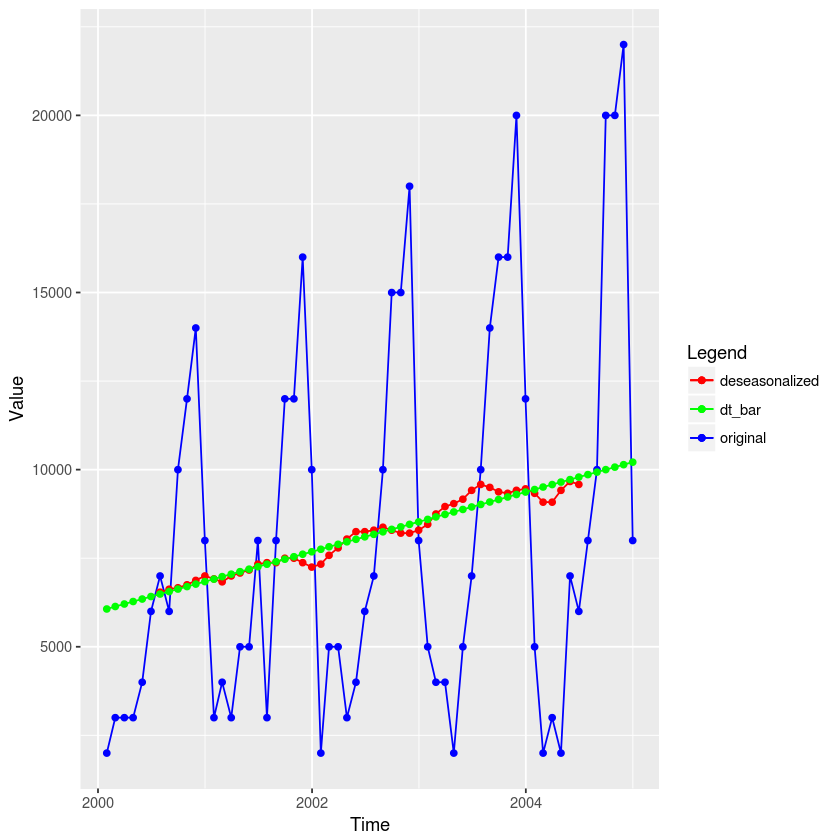

            t original deseasonalized    dt_bar    st_bar
2000-01-31  0     2000             NA  6067.506 0.3296247
2000-02-29  1     3000             NA  6137.752 0.4887783
2000-03-31  2     3000             NA  6207.998 0.4832476
2000-04-30  3     3000             NA  6278.244 0.4778406
2000-05-31  4     4000             NA  6348.489 0.6300711
2000-06-30  5     6000             NA  6418.735 0.9347636
2000-07-31  6     7000       6541.667  6488.981 1.0787518
2000-08-31  7     6000       6625.000  6559.227 0.9147420
2000-09-30  8    10000       6666.667  6629.473 1.5084156
2000-10-31  9    12000       6750.000  6699.718 1.7911201
2000-11-30 10    14000       6875.000  6769.964 2.0679578
2000-12-31 11     8000       7000.000  6840.210 1.1695547
2001-01-31 12     3000       6916.667  6910.456 0.4341248
2001-02-28 13     4000       6833.333  6980.702 0.5730083
2001-03-31 14     3000       7000.000  7050.947 0.4254747
2001-04-30 15     5000       7083.333  7121.193 0.7021295
2001-05-31 16 

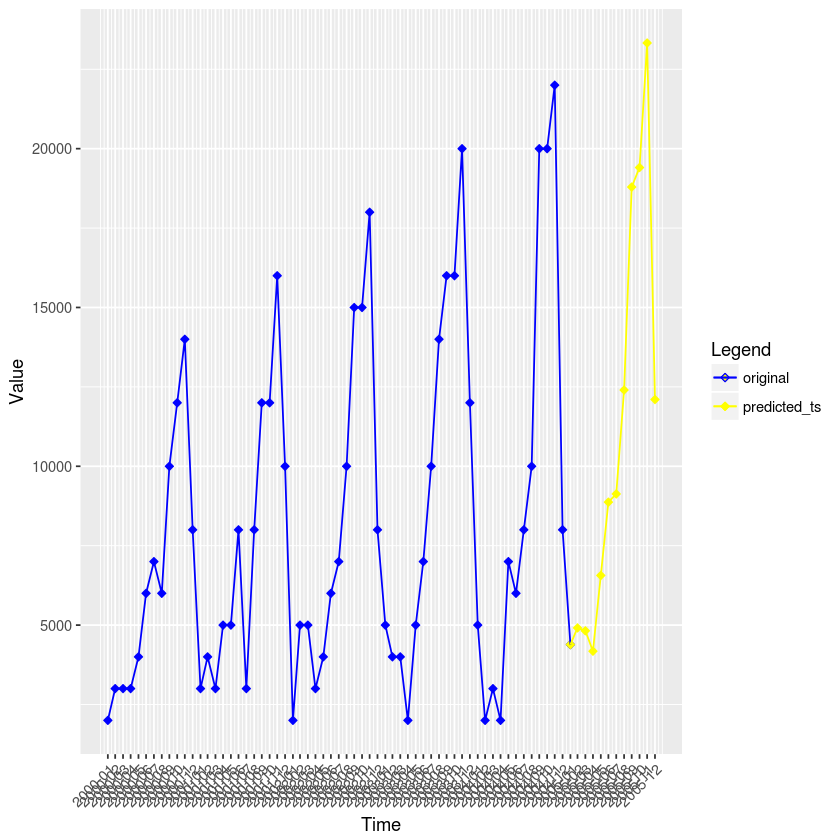

In [21]:
# Data Input
month_start <- 1 #user input

forecast_df <- read.xls("forecast.xlsx") #user input

sDate <- as.Date("2000-02-01", format = "%Y-%m-%d") 
eDate <- as.Date("2005-01-01", format = "%Y-%m-%d") 
date <- seq.Date(sDate, eDate, by = "month") - 1 #user input

forecast <- xts(forecast_df$sales, order.by = date)
ser <- forecast_df$sales

# p,r
p <- 12 # user input
r <- 5 # user input

# prediction
start_pred_date <- as.Date("2005-02-01") #user input

# function call
forecast_timeseries(ser, date, p, r, start_pred_date, month_start = 1, m_gap = "1 month")



Warning message:
“Removed 4 rows containing missing values (geom_point).”Warning message:
“Removed 4 rows containing missing values (geom_path).”

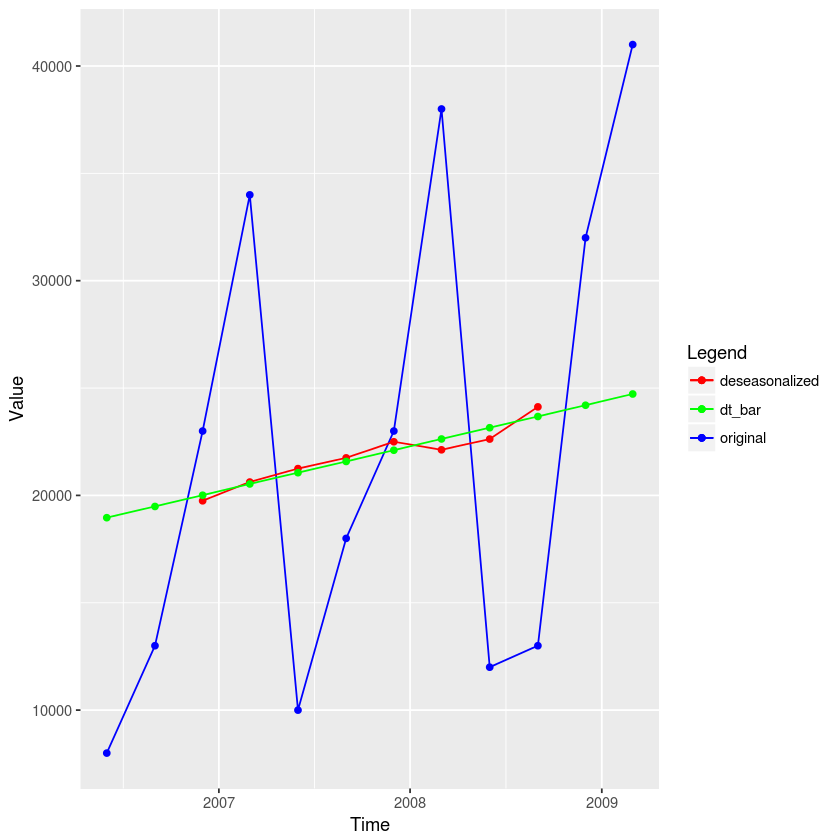

            t original deseasonalized   dt_bar    st_bar
2006-06-01  0     8000             NA 18962.80 0.4218787
2006-09-01  1    13000             NA 19486.61 0.6671249
2006-12-01  2    23000          19750 20010.42 1.1494014
2007-03-01  3    34000          20625 20534.23 1.6557722
2007-06-01  4    10000          21250 21058.04 0.4748781
2007-09-01  5    18000          21750 21581.85 0.8340343
2007-12-01  6    23000          22500 22105.65 1.0404578
2008-03-01  7    38000          22125 22629.46 1.6792267
2008-06-01  8    12000          22625 23153.27 0.5182852
2008-09-01  9    13000          24125 23677.08 0.5490541
2008-12-01 10    32000             NA 24200.89 1.3222653
2009-03-01 11    41000             NA 24724.70 1.6582606
2009-06-01 12    11909              0 25248.00 0.0000000
2009-09-01 13    17612              0 25772.00 0.0000000
2009-12-01 14    30785              0 26296.00 0.0000000
2010-03-01 15    44639              0 26819.00 0.0000000


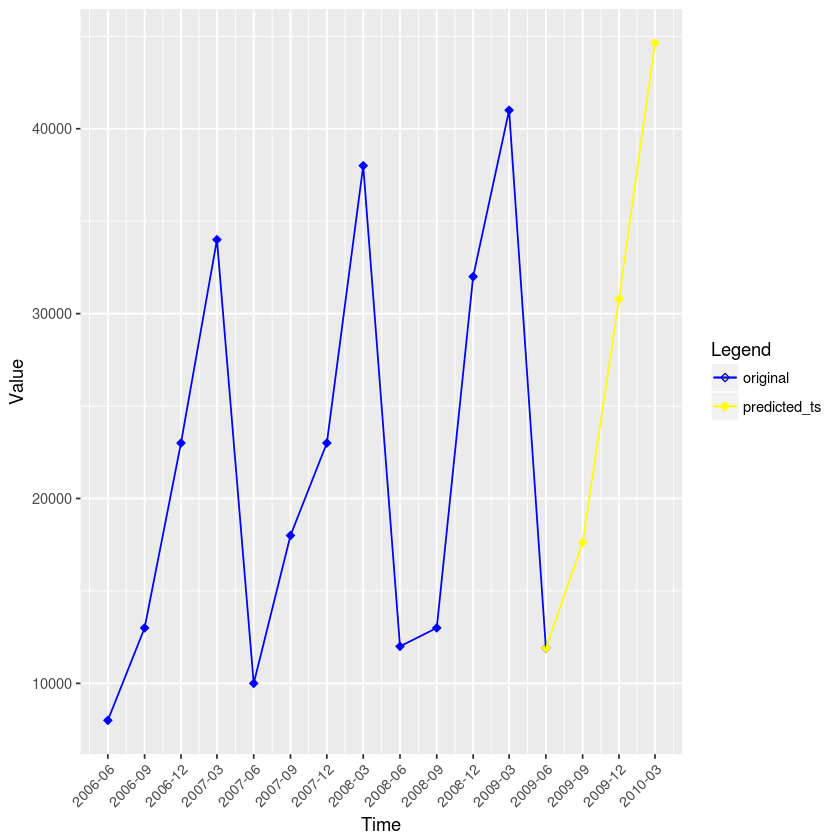

In [22]:
# Data Input

# Time Series
ser <- c(8, 13, 23, 34, 10, 18, 23, 38, 12, 13, 32, 41) * 1000

# Time Stamps
date <- as.Date(c("2006-06-01", "2006-09-01", "2006-12-01", "2007-03-01", "2007-06-01", "2007-09-01", "2007-12-01"
                    ,"2008-03-01", "2008-06-01", "2008-09-01", "2008-12-01", "2009-03-01"))

# p, r
p <- 4
r <- 3

# prediction
start_pred_date <- as.Date("2009-06-01") #user input

forecast_timeseries(ser, date, p, r, start_pred_date, month_start = 0, m_gap = "3 month")
